In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.style import use
from tqdm import tqdm, trange

from calculo.canonicalVectors import positiveX, negativeX
from calculo.video import centroid


def center_of_square(contour):
    return centroid(*cv2.boundingRect(contour))


def image_proccess(frame):
    kernel = np.ones((5,5),np.uint8)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    binary = cv2.threshold(dilation, 240., 255., cv2.THRESH_BINARY)[1]
    contours= cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    mark = np.array(map(center_of_square, contours))
    return mark.shape[0], mark


def roi_center(array, amp=1.4):
    y1 = array[0][1]
    y2 = array[-1][1]
    dy = (y1 - y2)*amp
    center = (y1 + y2) / 2
    return(center - dy, center +  dy)  # límite superior, límite inferior


def grouping(markers, n_expected, kroi=False):
    if kroi:
        Y = markers[:, 1]
        G0 = markers[Y < kroi[0]]
        G1 = markers[np.logical_and(Y > kroi[0], Y < kroi[1])]
        G2 = markers[Y > kroi[1]]
    else:
        G0 = markers[5:, :]
        G1 = markers[3:5, :]
        G2 = markers[:3, :]
    n_obtained = (G0.shape[0], G1.shape[0], G2.shape[0])
    boolean_interpolate = [a != b for a, b in zip(n_expected, n_obtained)]
    return(boolean_interpolate, (G0, G1, G2))


def diff(array, dt=1):
    vel = []
    for prev, new in zip(array[:-1], array[1:]):
        if prev and new:
            vel.append((new - prev) / dt)
        else:
            vel.append(None)
    vel.append(dt)  # este ultimo es arbitrario, pero no puede ser 0 o None
    return vel


def get_direction(foot_group):
    x_antepie = foot_group[0, 0]
    x_talon = foot_group[1, 0]
    if x_talon < x_antepie:
        return 1
    else:
        return -1


def sort_foot_markers(foot, direction=False):
    if foot.shape[0] != 3 and direction:
        return None
    x1, x2, refer = foot[:, 0]
    if direction:
        if direction > 0:
            if x1 < x2:
                talon = foot[0]
                antepie = foot[1]
            else:
                talon = foot[1]
                antepie = foot[0]
        elif direction < 0:
            if x1 < x2:
                talon = foot[1]
                antepie = foot[0]
            else:
                talon = foot[0]
                antepie = foot[1]
    else:
        values = ((abs(refer - x1), 0),
                  (abs(refer - x2), 1))
        talon = foot[min(values)[1]]
        antepie = foot[max(values)[1]]            
    maleolo = foot[-1]
    return np.array((antepie, talon, maleolo))


def set_direction(foot_markers, M=3):
    Y = map(lambda m: m[0][1] if  (isinstance(m, np.ndarray) and m.shape[0] != 0) else np.random.randint(0, 1000), foot_markers)
    vel = diff(Y)
    direction = 0
    for v , arr in zip(vel, foot_markers):
        if v == 0 and arr.shape[0] == M:
            sorted_foot = sort_foot_markers(arr)
            direction += get_direction(sorted_foot)
    return 1 if direction > 0 else -1


def linear(x, x1, x2, y1, y2):
    num = (x - x1)*(y2 - y1)
    div = (x2 - x1)
    if not div.all():
        return (y2 + y1) / 2
    return num / div + y1


def interpolate(A, B, n_steps):
    n_steps += 1
    x1, y1 = A.T
    x2, y2 = B.T
    dx = np.round((x2 - x1) / float(n_steps))
    interpolated = []
    for n in xrange(1, n_steps):
        X = x1 + dx*n
        Y = linear(X, x1, x2, y1, y2)
        interpolated.append(np.array((X, Y), dtype=int).T)
    return interpolated



def interval(index_to_interpolate):
    if not index_to_interpolate:
        return
    index = [x for x in index_to_interpolate]
    Xi = index.pop(0)
    if not index:
        yield Xi-1, Xi+1
        return
    it = []
    it.append(Xi)
    for i, Xj in enumerate(index):
        
        if (Xj - Xi) > 1:
            yield it[0] - 1, it[-1] + 1
            it = [Xj]
        else:
            it.append(Xj)
        Xi = Xj
    yield it[0] - 1, Xj + 1



def homogenize(binary, iterations=5):
    kernel = 1
    for __ in xrange(iterations):
        for i, value in enumerate(binary):
            binary[i] += kernel + 1
            kernel = value
        for i, value in enumerate(binary):
            if value == 1:
                binary[i] = 0
    for i, value in enumerate(binary):
        if value == 0:
            for j in xrange(1, iterations + 1):
                binary[i - j] = 0
        else:
            binary[i] = 1

            
def mov_validation(foot_movement, cycle):
    u"""Validar velocidad armónica en los marcadores de pie."""
    validate = 0
    for movement in foot_movement:
        movcopy = movement[cycle[0][0]: cycle[1][1]+1]
        temp = movcopy.pop(movcopy.index(max(movcopy)))
        level = temp * 0.5  # DEBUG(HARDCORE): se setea un nivel alto.
        for j in xrange(10):
            M = movcopy.pop(movcopy.index(max(movcopy)))
            if (temp - M) < level:
                if j == 0:
                    validate += 1
                break
            temp = M
    if validate == 2:
        return True, cycle
    else:
        return False, None


def Angle(A, B):
    """Calcula el ángulo(theta) entre dos arreglos de vectores(fila) según la
        definición de producto escalar:
            u·v = |u||v|cos(theta)
    Args:
        A: arreglo ``np.array`` de vectores fila con las posiciones x, y
            respectivamente de un punto en el plano.
        B: lo mismo que A
    Returns:
        arreglo ``np.array`` de ángulos en grados.
    """
    NA = np.linalg.norm(A, axis=1)
    NB = np.linalg.norm(B, axis=1)
    AB = A.dot(B.T).diagonal()
    radians = np.arccos(AB / (NA * NB))
    return np.degrees(radians)


def fourierfit(array, sample=101, amplitud=4):
    u"""Devuelve una aproximación de fourier con espectro que se
    define en ``amplitud``. Por defecto la muestra es de 101
    valores, sin importar el tamaño de ``array``
    """
    scale = sample/float(array.shape[1])
    fdt = np.fft.rfft(array)
    fourier_fit = np.fft.irfft(fdt[:, :amplitud], n=sample)*scale
    return fourier_fit


def convert_px_cm(cmreference, pxdistance, cmscale=30):
    u"""."""
    if not cmreference:
        return 0
    return pxdistance * cmscale / cmreference


def metric_reference(metrics):
    u"""."""
    if not metrics.any():
        return 0
    distances = []
    X = np.sort(metrics[:, 0])
    for P0, P1 in zip(X[:-1], X[1:]):
        distances.append(abs(P0 - P1))
    return np.mean(distances)


def RMSE(X1, X):
   """Raiz del error cuadrático medio."""
   return np.sqrt(np.sum(np.power(X1 - X, 2))/101)

In [2]:
class Trayectoria(object):
    u"""."""

    
    def __init__(self):
        u"""."""
        self._start = None
        self._end = None
        self._fps = None
        self._fixed = False
        self._cycled = False
        self._frames = {0:[], 1:[], 2:[], 'index_order': []}
        self._to_interpolate = {0:[], 1:[], 2:[]}
        self._joints = {}

    @property
    def start_frame(self):
        return self._start

    @start_frame.setter
    def start_frame(self, index):
        if self._start is None:
            self._start = index

    @property
    def end_frame(self):
        return self._end

    @end_frame.setter
    def end_frame(self, index):
        if self._end is None:
            self._end = index
            self.num_frames = (index - self._start) + 1

    def add_frame(self, index, groups):
        u"""."""
        for i, g in zip((0, 1, 2), groups):
            self._frames[i].append(g)
        self._frames['index_order'].append(index)

    def add_to_interpolate(self, index, bgroups):
        u"""."""
        for i, bg in zip((0, 1, 2), bgroups):
            self._to_interpolate[i].append((index, bg))

    def rm_lastNframes(self, n):
        u"""."""
        for __ in xrange(n):
            self._frames[0].pop()
            self._frames[1].pop()
            self._frames[2].pop()
            self._frames['index_order'].pop()
            self._to_interpolate[0].pop()
            self._to_interpolate[1].pop()
            self._to_interpolate[2].pop()

    def fix_in(self):
        if self._fixed:
            return
        self._direction = set_direction(self._frames[2])
        self._frames[2] = [sort_foot_markers(X, self._direction) for X in self._frames[2]]
        for group in (0, 1, 2):
            indexes = self._to_interpolate[group]
            if indexes:
                for ai, bi in interval([i for i, b in indexes if b is True]):
                    ai -= self.start_frame
                    bi -= self.start_frame
                    dt = (bi - ai) - 1
                    A = self._frames[group][ai]
                    B = self._frames[group][bi]
                    for j, arr in zip(xrange(ai + 1, bi), interpolate(A, B, dt)):
                        self._frames[group][j] = arr
        self._fixed = True

    def cycle_definition(self, fps, level=0.1):
        u"""."""
        # primer proceso. Se detecta la situacion de apoyo y balanceo
        vel = []
        lmov = []
        for i in (0, 1):
            mov = diff([X[i][1] for X in self._frames[2]], 1/fps)
            vel.append(mov)
            lmov.append(mov)
            limit = max(vel[i]) * level  # DEBUG(HARDCORE): umbral de velocidad aceptado.
            vel[i] = [abs(x) > limit for x in vel[i]]
            homogenize(vel[i])
        phases = [not (x + y) < 2 for x, y in zip(vel[0], vel[1])]

        # segundo proceso. Se detectan ciclos dentro del trayecto.
        st = []  # stance 
        cycles = []
        for i, (prev, nextt) in enumerate(zip(phases[:-1], phases[1:])):
            if prev and not nextt:  # (prev:balanceo/nextt:apoyo)
                st.append(i+1)
            if nextt and not prev: # (prev:apoyo/nextt:balanceo)
                tf = i+1  # toeoff
            if len(st) == 2:
                ret, cycle = mov_validation(lmov, ((st[0], tf-1), (tf, st[1]-1)))
                if ret:
                    cycles.append(cycle)
                st = [st[-1]]
        self._footmov = lmov
        self._phases = phases
        self._cycles = cycles
        self._cycled = True

    def get_joints(self):
        u"""."""
        for i, cycle in enumerate(self._cycles):
            (ihs, ho),(to, ehs) = cycle
            markers = {}
            codenames = (('c', 'fs'), ('ts', 'fi'), ('pa', 'pp', 'ti'))
            for j in (0, 1, 2):
                group = np.array(self._frames[j])
                for k, name in enumerate(codenames[j]):
                    markers[name] = group[ihs: ehs+1, k, :]
            # El marcador de tronco no se está utilizando.
            tight = markers['fi'] - markers['fs']
            leg = markers['ti'] - markers['ts']
            foot = markers['pp'] - markers['pa']
            
            xdirection = (None, positiveX, negativeX)[self._direction]
            hip = 90 - Angle(tight, xdirection(tight.shape[0]))
            knee = hip + (Angle(leg, xdirection(leg.shape[0])) - 90)
            ankle = 90 - Angle(leg, foot)
            hip, knee, ankle = fourierfit(np.array((hip, knee, ankle)))
            self._joints[i] = {'hip': hip, 'knee': knee, 'ankle': ankle}

In [3]:
class Kinematic(object):
    
    def __init__(self, name, fps, cmreference, trayectories):
        u"""."""
        self.name = name
        self._fps = fps
        self._cmref = cmreference
        self._trayectories = trayectories
        self._lat = (None, 'right', 'left')
        self.joints = {'right': {'hip': [], 'knee': [], 'ankle': []},
                       'left': {'hip': [], 'knee': [], 'ankle': []}}
        self.long_stride = {'right': [], 'left': []}
        self.tmcycles = {'right': [], 'left': []}
        self.tmstand = {'right': [], 'left': []}
        self.tmswing = {'right': [], 'left': []}
        self._split_trayectories()
        self._nrights = len(self.joints['right']['hip'])
        self._nlefts = len(self.joints['left']['hip'])

    def __repr__(self):
        classname = self.__class__.__name__
        videoname = self.name
        return '%r: %s (right: %d, left: %d)' % (classname, videoname, self._nrights, self._nlefts)

    def get_joint(self, joint, lat, summary=True):
        u"""."""
        array = np.array(self.joints[lat][joint])
        if summary:
            array = np.array((array.mean(axis=0), array.std(axis=0)))
        return array

    def get_strides(self, lat, summary=True):
        u"""."""
        array = np.array(self.long_stride[lat])
        if summary:
            array = np.array((array.mean(axis=0), array.std(axis=0)))
        return array

    def get_times(self, lat, summary=True):
        u"""."""
        array = np.array((self.tmcycles[lat],
                          self.tmstand[lat],
                          self.tmswing[lat]))
        if summary:
            array = np.array((array.mean(axis=1), array.std(axis=1))).transpose()
        return array

    def get_phases(self, lat):
        tt, ap, bal = self.get_times(lat)[:, 0]
        return round(ap / tt, 2)*100,  round(bal / tt, 2)*100
    
    def get_cadency(self):
        u"""."""
        cd = ((120 / self.get_times('right')[0][0]) +
              (120 / self.get_times('left')[0][0]))
        return round(cd / 2) 

    def get_velocity(self):
        u"""."""
        vl = ((self.get_strides('right')[0] / self.get_times('right')[0][0] / 100) +
              (self.get_strides('left')[0] / self.get_times('left')[0][0] / 100))
        return round(vl / 2, 2)

    def _split_trayectories(self):
        u"""."""
        for t in self._trayectories:
            t.fix_in()
            t.cycle_definition(self._fps)
            t.get_joints()
            if t._cycles:
                for i in xrange(len(t._cycles)):  # joints
                    self.joints[self._lat[t._direction]]['hip'].append(t._joints[i]['hip'])
                    self.joints[self._lat[t._direction]]['knee'].append(t._joints[i]['knee'])
                    self.joints[self._lat[t._direction]]['ankle'].append(t._joints[i]['ankle'])
                for (ihs, __), (sw, ehs) in t._cycles:  # distances and times
                    X0 = t._frames[2][ihs][1]
                    X1 = t._frames[2][ehs+1][1]
                    self.long_stride[self._lat[t._direction]].append(
                        convert_px_cm(self._cmref, np.linalg.norm(X0 - X1))
                    )
                    self.tmcycles[self._lat[t._direction]].append((ehs - ihs) / fps)
                    self.tmstand[self._lat[t._direction]].append((sw - ihs) / fps)
                    self.tmswing[self._lat[t._direction]].append((ehs - sw) / fps)

In [4]:
def video_proccess(path):
    vid = cv2.VideoCapture(path)
    fps = vid.get(cv2.CAP_PROP_FPS)
    frames_num = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    expected_markers = (2, 2, 3)
    M = sum(expected_markers)
    safe_None = 1.5 * fps
    last_M = 0
    active = False
    count_non_data = 0
    trayectories = []
    n_metrics = 5
    metrics = np.zeros((1, 1))

    t = Trayectoria()
    for i in xrange(frames_num):
        __, frame = vid.read()
        m, mark = image_proccess(frame)
        if mark.any():
            if m == M:
                active = True
                t.start_frame = i
                last_M = i
                count_non_data = 0
    ############################################################################################################
    # Se adiciona código para obtener metricas.
    # Esta parte del codigo es peligrosa.. debe hacerce notar la importancia de inciar con metricas cada video.
            if (not metrics.any() and not active) and i < 10:
                if m == n_metrics:
                    metrics = mark
    ############################################################################################################
            if active:
                if m != M:
                    to_interp, groups = grouping(mark, expected_markers, kr)
                    t.add_frame(i, groups)
                    t.add_to_interpolate(i, to_interp)
                else:
                    __, groups = grouping(mark, expected_markers)
                    kr = roi_center(groups[1])
                    t.add_frame(i, groups)
        else:
            count_non_data += 1
            if active and count_non_data < safe_None:
                G0 = np.random.randint(0, 100, (2, 2))
                G1 = np.random.randint(0, 100, (2, 2))
                G2 = np.random.randint(0, 100, (3, 2))
                t.add_frame(i, (G0, G1, G0))
                t.add_to_interpolate(i, (True, True, True))
            else:
                if active:
                    backwards = (i - 1) - last_M
                    t.rm_lastNframes(backwards)
                    t.end_frame = i - backwards - 1
                    trayectories.append(t)
                    t = Trayectoria()
                    active = False
    return fps, metric_reference(metrics), trayectories

In [5]:
# path = '/home/mariano/Descargas/VID_20170720_132629833.mp4'  # Belen
# path = '/home/mariano/Descargas/VID_20170720_133000367.mp4'  # Belen corriendo
# path = '/home/mariano/Descargas/VID_20170728_112226772.mp4'  # Maxi Hissa
path1 = '/home/mariano/Descargas/VID_20170831_093451442.mp4'  # Ferrando v
path2 = '/home/mariano/Descargas/VID_20170831_095319235.mp4'  # Ferrando o
path3 = '/home/mariano/Descargas/VID_20170831_100017607.mp4'  # Ferrando l

kinematics = []
for path in (path1, path2, path3):
    vid = cv2.VideoCapture(path)
    fps = vid.get(cv2.CAP_PROP_FPS)
    frames_num = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    expected_markers = (2, 2, 3)
    M = sum(expected_markers)
    safe_None = 1.5 * fps
    last_M = 0
    active = False
    count_non_data = 0
    trayectories = []
    n_metrics = 5
    metrics = np.zeros((1, 1))

    t = Trayectoria()
    for i in tqdm(xrange(frames_num)):
        __, frame = vid.read()
        m, mark = image_proccess(frame)
        if mark.any():
            if m == M:
                active = True
                t.start_frame = i
                last_M = i
                count_non_data = 0
    ############################################################################################################
    # Se adiciona código para obtener metricas.
    # Esta parte del codigo es peligrosa.. debe hacerce notar la importancia de inciar con metricas cada video.
            if (not metrics.any() and not active) and i < 50:  # DEBUG HARDCORE
                if m == n_metrics:
                    metrics = mark
    ############################################################################################################
            if active:
                if m != M:
                    to_interp, groups = grouping(mark, expected_markers, kr)
                    t.add_frame(i, groups)
                    t.add_to_interpolate(i, to_interp)
                else:
                    __, groups = grouping(mark, expected_markers)
                    kr = roi_center(groups[1])
                    t.add_frame(i, groups)
        else:
            count_non_data += 1
            if active and count_non_data < safe_None:
                G0 = np.random.randint(0, 100, (2, 2))
                G1 = np.random.randint(0, 100, (2, 2))
                G2 = np.random.randint(0, 100, (3, 2))
                t.add_frame(i, (G0, G1, G0))
                t.add_to_interpolate(i, (True, True, True))
            else:
                if active:
                    backwards = (i - 1) - last_M
                    t.rm_lastNframes(backwards)
                    t.end_frame = i - backwards - 1
                    trayectories.append(t)
                    t = Trayectoria()
                    active = False

    ref = metric_reference(metrics)
    kinematics.append(Kinematic(path, fps, ref, trayectories))

100%|██████████| 3190/3190 [00:57<00:00, 57.79it/s]


In [6]:
Norm = pd.read_excel('normal.xlsx', index_col=(0, 1))

In [7]:
rows = ('Longitud Zancada [m]',
        'Tiempo Ciclo [s]',
        'Apoyo [%]',
        'Balanceo [%]',
        'Velocidad Media [m/s]',
        'Cadencia [p/m]',
        'EMC')
cols = {}
for n, name in enumerate(('3-Vendaje', '2-Ortesis', '1-Libre')): 
    K = kinematics[n]
    ecm = sum((RMSE(K.get_joint('hip', 'right')[0], Norm.loc['cadera', 'mean']),
               RMSE(K.get_joint('knee', 'right')[0], Norm.loc['rodilla', 'mean']),
               RMSE(K.get_joint('ankle', 'right')[0], Norm.loc['tobillo', 'mean'])))
    data = np.array((K.get_strides('right')[0],
             K.get_times('right')[0][0],
             K.get_phases('right')[0],
             K.get_phases('right')[1],
             K.get_velocity(),
             K.get_cadency(),
             ecm))
    cols[name] = data
    # dataL = [K.get_strides('left')[0],
    #          K.get_times('left')[0][0],
    #          K.get_phases('left')[0],
    #          K.get_phases('left')[1],
    #          K.get_velocity(),
    #          K.get_cadency(),
    #          0]  # falta esta función.
parametrosET = pd.DataFrame(cols, index=rows)
parametrosET.round(2)

,1-Libre,2-Ortesis,3-Vendaje
Longitud Zancada [m],0.00,151.16,136.09
Tiempo Ciclo [s],1.03,1.01,1.01
Apoyo [%],47.00,47.00,48.00
Balanceo [%],53.00,53.00,52.00
Velocidad Media [m/s],0.00,1.49,1.37
Cadencia [p/m],117.00,119.00,118.00
EMC,23.22,30.60,17.99


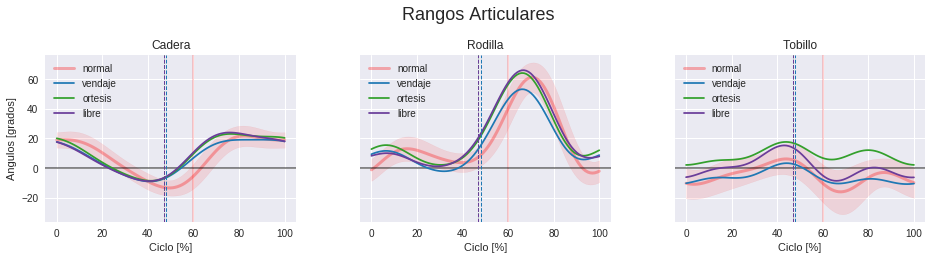

In [46]:
%matplotlib inline
use('seaborn')

fig, (hipax, kneeax, ankleax) = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.suptitle('Rangos Articulares', size=18)
fig.set_figheight(4)
fig.set_figwidth(14)
fig.tight_layout(pad=5)

# Normal
# cadera
hmean = Norm.loc['cadera', 'mean']
hsd = Norm.loc['cadera', 'sd']
hipax.set_title('Cadera')
lnorm, = hipax.plot(hmean, color='r', alpha=.3, linewidth=3)
hipax.fill_between(np.arange(hmean.size), hmean - hsd*2, hmean + hsd*2, color='r', alpha=.1)
hipax.axvline(60, color='r', alpha=.2)
hipax.axhline(0, 0, 100, color='k', alpha=.5)
hipax.set_xlabel('Ciclo [%]')
hipax.set_ylabel('Angulos [grados]')
# rodilla
kmean = Norm.loc['rodilla', 'mean']
ksd = Norm.loc['rodilla', 'sd']
kneeax.set_title('Rodilla')
kneeax.plot(kmean, color='r', alpha=.3, linewidth=3)
kneeax.fill_between(np.arange(kmean.size), kmean - ksd*2, kmean + ksd*2, color='r', alpha=.1)
kneeax.axvline(60, color='r', alpha=.2)
kneeax.axhline(0, 0, 100, color='k', alpha=.5)
kneeax.set_xlabel('Ciclo [%]')
# tobillo
amean = Norm.loc['tobillo', 'mean']
asd = Norm.loc['tobillo', 'sd']
ankleax.set_title('Tobillo')
ankleax.plot(amean, color='r', alpha=.3, linewidth=3)
ankleax.fill_between(np.arange(amean.size), amean - asd*2, amean + asd*2, color='r', alpha=.1)
ankleax.axvline(60, color='r', alpha=.2)
ankleax.axhline(0, 0, 100, color='k', alpha=.5)
ankleax.set_xlabel('Ciclo [%]')


K1, K2, K3 = kinematics
color = plt.get_cmap('Paired').colors
v, o, l = color[1], color[3], color[9]
#Angulos
#1
lvendaje, = hipax.plot(K1.get_joint('hip', 'right')[0], color=v)
kneeax.plot(K1.get_joint('knee', 'right')[0], color=v)
ankleax.plot(K1.get_joint('ankle', 'right')[0], color=v)
#2
lortesis, = hipax.plot(K2.get_joint('hip', 'right')[0], color=o)
kneeax.plot(K2.get_joint('knee', 'right')[0], color=o)
ankleax.plot(K2.get_joint('ankle', 'right')[0], color=o)
#3
llibre, = hipax.plot(K3.get_joint('hip', 'right')[0], color=l)
kneeax.plot(K3.get_joint('knee', 'right')[0], color=l)
ankleax.plot(K3.get_joint('ankle', 'right')[0], color=l)

# Fases
#1
hipax.axvline(K1.get_phases('right')[0], linestyle='--', linewidth=1, color=v)
kneeax.axvline(K1.get_phases('right')[0], linestyle='--', linewidth=1, color=v)
ankleax.axvline(K1.get_phases('right')[0], linestyle='--', linewidth=1, color=v)
#2
hipax.axvline(K2.get_phases('right')[0], linestyle='--', linewidth=1, color=o)
kneeax.axvline(K2.get_phases('right')[0], linestyle='--', linewidth=1, color=o)
ankleax.axvline(K2.get_phases('right')[0], linestyle='--', linewidth=1, color=o)
#3
hipax.axvline(K3.get_phases('right')[0], linestyle='--', linewidth=1, color=l)
kneeax.axvline(K3.get_phases('right')[0], linestyle='--', linewidth=1, color=l)
ankleax.axvline(K3.get_phases('right')[0], linestyle='--', linewidth=1, color=l)


#legends
hipax.legend(
    [lnorm, lvendaje, lortesis, llibre],
    ['normal', 'vendaje', 'ortesis', 'libre'],
    loc=2
)
kneeax.legend(
    [lnorm, lvendaje, lortesis, llibre],
    ['normal', 'vendaje', 'ortesis', 'libre'],
    loc=2
)
ankleax.legend(
    [lnorm, lvendaje, lortesis, llibre],
    ['normal', 'vendaje', 'ortesis', 'libre'],
    loc=2
)

plt.savefig('rangos.png', dpi=300)

In [9]:
# t = trayectories[1]
# (s, __), (__, e) = t._cycles[0]
# cyc = range(t._start + s, t._start + e + 1)

# from time import sleep

# vid = cv2.VideoCapture(path)
# n = 0
# i = 0
# j = 0
# font = cv2.FONT_HERSHEY_TRIPLEX
# while True:
#     is_frame, frame = vid.read()
#     wait = 0
#     if is_frame is False:
#         break
#     if n >= t._start and n <= t._end:
#         wait = .15
#         color = (0, 255, 255)
#         arr = t._frames[0][i]
#         kn = t._frames[1][i][0]
#         hp = t._frames[0][i][0]
#         ak = t._frames[2][i][0]
#         if n in cyc:
#             color = (0, 0, 255)
#             thp = str(round(t._joints.values()[0]['hip'][j], 2))
#             tkn = str(round(t._joints.values()[0]['knee'][j], 2))
#             tak = str(round(t._joints.values()[0]['ankle'][j], 2))
#             cv2.putText(frame, thp, (hp[0], hp[1]), font, 1.2, color)
#             cv2.putText(frame, tkn, (kn[0], kn[1]), font, 1.2, color)
#             cv2.putText(frame, tak, (ak[0], ak[1]), font, 1.2, color)
#             j += 1
#         for m in arr: 
#             cv2.circle(frame, (m[0], m[1]), 7, color, -1)
#         i += 1
#     cv2.imshow(path, cv2.resize(frame, None, fx=.4, fy=.4))
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
#     n += 1
#     sleep(wait)
# vid.release()
# cv2.destroyAllWindows()


In [10]:
# # Este codigo se me ocurre como opción para debuguear.
# for t in trayectories:
#     print t._direction
#     t.cycle_definition(fps,.13)
#     plt.plot(t._footmov[0])
#     plt.plot(t._footmov[1])
#     plt.plot(np.array(t._phases)*1000)
#     plt.show()

In [11]:
# posible codigo para saber la cantidad de cuadros interpolados por ciclo por grupo
# for t in trayectories:
#     for c in t._cycles:
#         (s, __), (__, e) = t._cycles[c]
#         cyc = range(t._start + s, t._start + e + 1)
#         for i in (0, 1, 2):
#             inter = zip(t._to_interpolate['index_order'], t._to_interpolate[i])
#             cc = sum([True for z in ciclo if z in [x for x, y in inter if y]])
#             print cc